# INTRO

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import tensorflow as tf
import numpy as np
import json


# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()

from google.colab import drive
drive.mount('/content/drive/')

data_dir=r"/content/drive/MyDrive/anndl-2020-vqa.zip (Unzipped Files)/VQA_Dataset"
image_dir=r"/content/drive/MyDrive/anndl-2020-vqa.zip (Unzipped Files)/VQA_Dataset/Images"

os.listdir(data_dir)


Mounted at /content/drive/


['Images', 'test_questions.json', 'train_questions_annotations.json', 'Splits']

# PREPROCESSING TEXT

In [ ]:
question_sentences = []
answer = []
question_sentences_test = []


f=open(os.path.join(data_dir, 'train_questions_annotations.json'), encoding='utf-8')
g=json.load(f)
count=0
for line in g:
  answer.append(g[line]['answer'] ) 
  h=g[line]['question']
  question_sentences.append( '<sos>' + h.replace('?', ''))

length=len(answer)

type(question_sentences[0])
print('\n')

f=open(os.path.join(data_dir, 'test_questions.json'), encoding='utf-8')
g=json.load(f)
for line in g:
  h=g[line]['question']
  question_sentences_test.append( '<sos>' + h.replace('?', ''))


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_NUM_WORDS=60000

# Create Tokenizer to convert words to integers
quest_tokenizer = Tokenizer(num_words= MAX_NUM_WORDS)
quest_tokenizer.fit_on_texts(question_sentences)
quest_tokenized = quest_tokenizer.texts_to_sequences(question_sentences)

quest_wtoi = quest_tokenizer.word_index
print('Total question words:', len(quest_wtoi))
max_quest_length = max(len(sentence) for sentence in quest_tokenized)
print('Max question sentence length:', max_quest_length)
quest_encoder_inputs = pad_sequences(quest_tokenized, maxlen=max_quest_length)
type(quest_encoder_inputs)



num_answers=58
labels_dict =  {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
  }


ans_indices = [labels_dict[a] for a in answer]
ans_Y = tf.keras.utils.to_categorical(ans_indices)


str



Total question words: 4641
Max question sentence length: 22


numpy.ndarray

# PREPROCESSING IMAGE


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = False

# Create training ImageDataGenerator object

if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
else:
    img_data_gen = ImageDataGenerator(rescale=1./255)
    

In [ ]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    

    f=open(os.path.join(data_dir, 'train_questions_annotations.json'), encoding='utf-8')   
    subset_file=json.load(f)
    
    subset_filenames = []
    answer=[]

    for line in subset_file:
      subset_filenames.append(subset_file[line]['image_id'])
      
    
    
    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename + '.png'))
    

    # Resize image and mask
    img = img.resize([256,256]) ##MANUALE
    
    img_arr = np.array(img)[...,:3]
    arr=img_arr
    img_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')



    if self.which_subset == 'training':
      if self.img_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        
    
      
    
    if self.preprocessing_function is not None:
      img_arr = self.preprocessing_function(img_arr)
    
    q=quest_encoder_inputs[index] ##extract from text preprocessing
  
    a=ans_Y[index]

    #inputs=(img_arr,q)
    inputs={'input_2': img_arr,'input_3':q}

    output=a

    return inputs,output

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 256
img_w = 256

dataset = CustomDataset(data_dir, 'training', 
                        img_generator=img_data_gen,  #else=img_data_gen
                        preprocessing_function=preprocess_input)



types = ( (tf.float32,tf.int64), (tf.int64) ) 
shapes = (([img_h, img_w, 3],[max_quest_length]),
          [58])

types2= ( { 'input_2':tf.float32, 'input_3' : tf.int64}, tf.int64) 
shapes2 = ({ 'input_2':[img_h, img_w, 3], 'input_3' : [max_quest_length]},
          [58])

full_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=types2,
                                               output_shapes=shapes2)

bs=32
train_size = int(0.8 * length)
valid_size=length-train_size

#full_dataset = full_dataset.shuffle()
train_dataset = full_dataset.take(train_size)
valid_dataset = full_dataset.skip(train_size)


train_dataset = train_dataset.batch(bs)
train_dataset = train_dataset.repeat()
valid_dataset = valid_dataset.batch(bs)
valid_dataset = valid_dataset.repeat()


In [ ]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline


train_dataset
next(iter(train_dataset))[0]['input_2']


<RepeatDataset shapes: ({input_2: (None, 256, 256, 3), input_3: (None, 22)}, (None, 58)), types: ({input_2: tf.float32, input_3: tf.int64}, tf.int64)>

UnknownError: ignored

# MODEL

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 22)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 22, 32)       148544      input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 32)           8320        embedding[0][0]                  
_____________________________

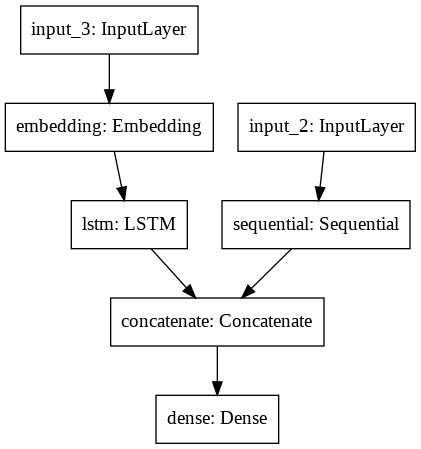

In [ ]:
# Import Keras 
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model, Sequential

vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

finetuning=True

if finetuning:
    freeze_until = -6 
    
    for layer in vgg.layers[:freeze_until]:
        layer.trainable = False
else:
    vgg.trainable = False


# Define CNN for Image Input
vision_model = Sequential()
vision_model.add(vgg)
vision_model.add(Flatten())

image_input = Input(shape=(256, 256,3)) #remove 3 in fondo
encoded_image = vision_model(image_input)

# Define RNN for language input
EMBEDDING_SIZE = 32

question_input = Input(shape=[max_quest_length])
embedded_question = Embedding(len(quest_wtoi)+1, EMBEDDING_SIZE, input_length=max_quest_length)(question_input)
encoded_question = LSTM(EMBEDDING_SIZE)(embedded_question)

from tensorflow.keras.layers import Multiply
# Combine CNN and RNN to create the final model
#merged = tf.keras.layers.concatenate([encoded_question, encoded_image]) Multiply()

merged = tf.keras.layers.concatenate([encoded_question, encoded_image])
output = Dense(58, activation='softmax')(merged)
model = Model(inputs=[image_input, question_input], outputs=output)

model.summary()
tf.keras.utils.plot_model(model)

In [ ]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join('/content/drive/My Drive/KerasRNN', 'translation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

exp_name = 'exp'

exp_dir = os.path.join(exps_dir, exp_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# ----------------

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    callbacks.append(es_callback)

# ---------------------------------



# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

# RUNN

In [ ]:

model.fit(
  x=train_dataset,
  shuffle=True,
  epochs=20,
  steps_per_epoch=train_size/bs,
  validation_data=valid_dataset,
  validation_steps=valid_size/bs,
  callbacks=callbacks
)


Epoch 1/20
1470/1470 [==============================] - 10194s 7s/step - loss: 3.2557 - accuracy: 0.3018 - val_loss: 1.5929 - val_accuracy: 0.4341
Epoch 2/20
1470/1470 [==============================] - 2150s 1s/step - loss: 1.5771 - accuracy: 0.4285 - val_loss: 1.4502 - val_accuracy: 0.4717
Epoch 3/20
1470/1470 [==============================] - 2057s 1s/step - loss: 1.4166 - accuracy: 0.4734 - val_loss: 1.3183 - val_accuracy: 0.4954
Epoch 4/20
1470/1470 [==============================] - 2136s 1s/step - loss: 1.2696 - accuracy: 0.5206 - val_loss: 1.2204 - val_accuracy: 0.5379
Epoch 5/20
1470/1470 [==============================] - 2076s 1s/step - loss: 1.1723 - accuracy: 0.5587 - val_loss: 1.1683 - val_accuracy: 0.5576
Epoch 6/20
1470/1470 [==============================] - 2295s 2s/step - loss: 1.1044 - accuracy: 0.5808 - val_loss: 1.1337 - val_accuracy: 0.5685
Epoch 7/20
1470/1470 [==============================] - 2068s 1s/step - loss: 1.0558 - accuracy: 0.5979 - val_loss: 1.1083 